$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Linear Regression with Fixed Nonlinear Features

The models we have been buildling are linear in the parameters $\wv$
and linear in the attributes (features) of the samples.  We can make
models that are nonlinear in the attributes by adding nonlinear
functions of the original features.  

Say we have a single feature for each sample.  Our data matrix is
$$
\begin{alignat*}{1}
 X &= \begin{bmatrix}
       x_0\\
       x_1\\
       \vdots \\
       x_N
       \end{bmatrix}
\end{alignat*}
$$
We can add other powers of each $x$ value, say up to the fourth power.
$$
\begin{alignat*}{1}
 X &= \begin{bmatrix}
       x_0 & x_0^2 & x_0^3 & x_0^4\\
       x_1 & x_1^2 & x_1^3 & x_1^4\\
       \vdots \\
       x_N & x_N^2 & x_N^3 & x_N^4\\
       \end{bmatrix}
\end{alignat*}
$$

This is simple to do in python.

    X = np.hstack((X, X**2, X**3, X**4))

Which of these powers of $x$ are useful?  Looking at the magnitudes of
the weights is helpful, as long as the input features are
standardized.  We can do more than this, though.  If we build multiple
models from multiple bootstrap samples of the training data, we can
compute confidence intervals of the weight values.  If zero is
not included in the range of
weight values specified by a weight's 90% lower and
upper confidencce limit, then we can say that we are 90% certain that
the value of this weight is not zero.  If the range does include zero,
the corresponding feature is probably one that is not useful.

Here is some code that illustrates this whole process, including the
use of the penalty on weight magnitudes controlled by $\lambda$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random
import scipy.stats as st # for st.norm.cdf and ppf in bcaIntervals

We will need our *standardize* function.  Let's also write functions for creating and using a linear least squares model.

In [3]:
def makeStandardize(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    def standardize(origX):
        return (origX - means) / stds
    def unStandardize(stdX):
        return stds * stdX + means
    return (standardize, unStandardize)

def makeLLS(X,T,lambdaw):
    (standardizeF, unstandardizeF) = makeStandardize(X)
    X = standardizeF(X)
    (nRows,nCols) = X.shape
    X = np.hstack((np.ones((X.shape[0],1)), X))    
    penalty = lambdaw * np.eye(nCols+1)
    penalty[0,0]  =0  # don't penalize the bias weight
    w = np.linalg.lstsq(np.dot(X.T,X)+penalty, np.dot(X.T,T))[0]
    return (w, standardizeF, unstandardizeF)

def useLLS(model,X):
    w, standardizeF, _ = model
    X = standardizeF(X)
    X = np.hstack((np.ones((X.shape[0],1)), X))
    return np.dot(X,w)

And don't forget our function for determining bootstrap confidence intervals, using the bias-corrected, accelerated method.

In [4]:
def bcaIntervals(ys, prob=90):
  r = len(ys)
  Z = st.norm.ppf( np.sum(ys < np.mean(ys)) / float(r) )
  loos = (np.sum(ys) - ys) / (len(ys)-1)
  loosMeanSubtracted = loos - np.mean(loos)
  A = np.sum(loosMeanSubtracted**3) / (6 * np.sum(loosMeanSubtracted**2)**(3/2.0))
  z = st.norm.ppf(1 - (100-prob)/2.0/100.0)
  A1 = st.norm.cdf(Z + (Z-z)/(1-A*(Z-z)))
  A2 = st.norm.cdf(Z + (Z+z)/(1-A*(Z+z)))
  loweri = int(round(r * A1))
  upperi = int(round(r * A2))
  ys = np.sort(ys)
  CI = (ys[loweri],ys[upperi])
  return CI

Let's add squared and cubed values of each feature.

In [5]:
def addFeatures(X):
    return np.hstack((X, X**2, X**3))

addFeatures( np.array([[1,2],[3,4]]))

array([[ 1,  2,  1,  4,  1,  8],
       [ 3,  4,  9, 16, 27, 64]])

Now, make a simple function of $x$. How about $f(x) = -1 + 0.1 x^2 - 0.02 x^3 + 0.5 n$, where $n$ is from a standard Normal distribution.

In [6]:
nSamples = 40
trainingFraction = 0.5
nModels = 1000
confidence = 90 # percent
lambdaw = 0.0 # penalty on weight magnitudes

X = np.hstack((np.linspace(0, 3, num=nSamples),
               np.linspace(6, 10, num=nSamples))).reshape((2*nSamples,1))
# T = -1 + 1 * X + 2 * np.sin(X*2) + 0.55*np.random.normal(size=(2*nSamples,1))
T = -1 + 0 * X + 0.1 * X**2 - 0.02 * X**3 + 0.5*np.random.normal(size=(2*nSamples,1))
X.shape, T.shape

((80, 1), (80, 1))

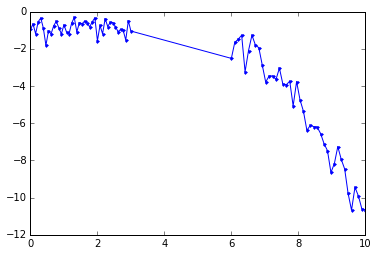

In [7]:
plt.plot(X,T,'.-');

Divide data into training and testing sets, randomly.

In [8]:
nRows = X.shape[0]
nTrain = int(round(nRows*trainingFraction))
nTest = nRows - nTrain
allI = range(nRows)
trainI = random.sample(allI,nTrain)
testI = list(set(allI).difference(set(trainI)))

Xtrain = X[trainI,:]
Ttrain = T[trainI,:]
Xtest = X[testI,:]
Ttest = T[testI,:]

Xtrain = addFeatures(Xtrain)
Xtest = addFeatures(Xtest)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((40, 3), (40, 1), (40, 3), (40, 1))

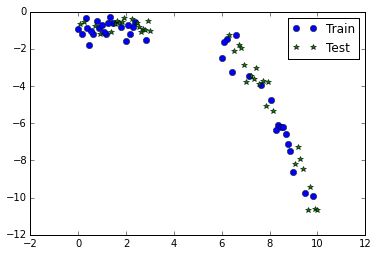

In [9]:
plt.plot(Xtrain[:,0],Ttrain,'o',label='Train')
plt.plot(Xtest[:,0],Ttest,'*',label='Test')
plt.xlim(-2,12)
plt.legend(loc='best')

Make models based on bootstrap samples of training data.  *models* will be list of models, one for each bootstrap sample.

In [10]:
models = []
for modeli in range(nModels):
    trainI = [random.randint(0,nTrain-1) for i in range(nTrain)]
    XtrainBoot = Xtrain[trainI,:]
    TtrainBoot = Ttrain[trainI,:]
    model = makeLLS(XtrainBoot,TtrainBoot,lambdaw)
    models.append(model)

Now we will apply all of the models to the test data.

In [11]:
YAll = []
for model in models:
    YAll.append( useLLS(model,Xtest) )
YAll = np.array(YAll).squeeze().T 
Ytest = np.mean(YAll,axis=1)
Ttest = Ttest.flatten()  ## WATCH OUT!! Next line produces wrong scalar without this line!
RMSEtest = np.sqrt(np.mean((Ytest - Ttest)**2))
print('Test RMSE is {:.4f}'.format(RMSEtest))

Test RMSE is 0.5573


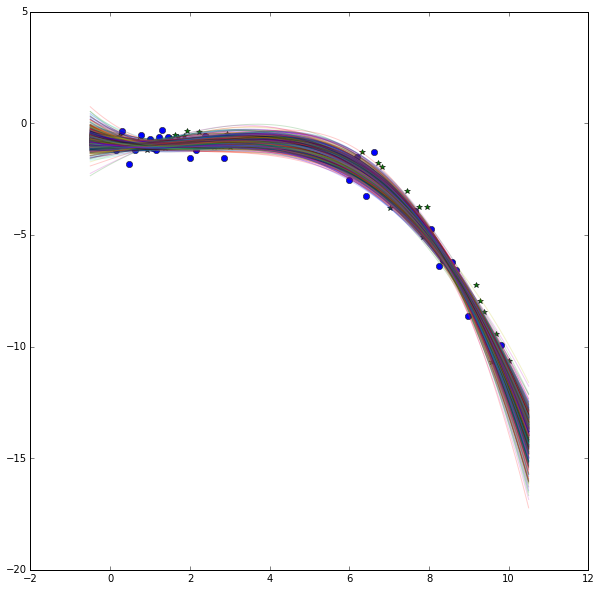

In [12]:
nPlot = 100
Xplot = np.linspace(-0.5,10.5,nPlot).reshape((nPlot,1))
Xplot = addFeatures(Xplot)
Ys = []
for model in models:
    Yplot = useLLS(model,Xplot)
    Ys.append( Yplot.flatten())
Ys = np.array(Ys).T

plt.figure(figsize=(10,10))
plt.plot(Xtrain[:,0],Ttrain,'o')
plt.plot(Xtest[:,0],Ttest,'*')
plt.plot(Xplot[:,0],Ys,alpha=0.2);

Examine confidence limits of weights

In [13]:
import math as ma

confidenceFraction = (1-confidence/100.0)/2.0
loweri = int(ma.ceil(nModels*confidenceFraction))
upperi = int(ma.floor(nModels*(1-confidenceFraction)))

lower = np.zeros((nPlot))
upper = np.zeros((nPlot))
for xi in range(nPlot):
    predictions = Ys[xi,:]
    predictions.sort()
    lower[xi] = predictions[loweri]
    upper[xi] = predictions[upperi]

WAll = np.array([model[0][:,0] for model in models]).T # collect the weight matrices from all models

nAttributes = WAll.shape[0]
lowerW = np.zeros((nAttributes))
upperW = np.zeros((nAttributes))
for wi in range(nAttributes):
    wis = WAll[wi,:]
    wis.sort()
    lowerW[wi] = wis[loweri]
    upperW[wi] = wis[upperi]

### Again, but this time use Bias-Corrected, Accelerated version

lowerbcaW = np.zeros((nAttributes))
upperbcaW = np.zeros((nAttributes))
for wi in range(nAttributes):
    wis = WAll[wi,:]
    lowerbcaW[wi],upperbcaW[wi] = bcaIntervals(WAll[wi,:])

print('Weights:')
formatString = 'weight {:d} median= {:7.3f} range= {:7.3f} to {:7.3f}, bca range= {:7.3f} to {:7.3f}'
for wi in range(nAttributes):
    print(formatString.format(wi, np.median(WAll[wi,:]),lowerW[wi],upperW[wi],lowerbcaW[wi],upperbcaW[wi]))

Weights:
weight 0 median=  -2.912 range=  -3.717 to  -2.196, bca range=  -3.779 to  -2.222
weight 1 median=  -0.718 range=  -2.119 to   0.625, bca range=  -2.186 to   0.594
weight 2 median=   4.717 range=   1.664 to   8.740, bca range=   1.799 to   8.970
weight 3 median=  -6.735 range=  -9.403 to  -4.639, bca range=  -9.547 to  -4.822


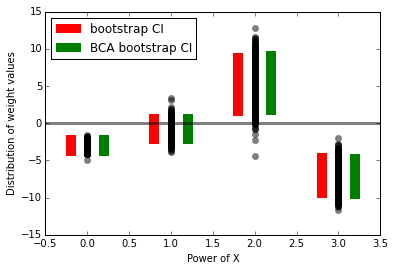

In [14]:
for i in range(nAttributes):
    plt.plot([i]*WAll.shape[1],WAll[i,:],'ko',alpha=0.5)
plt.xlim(-0.5,nAttributes-0.5);
plt.xlabel("Power of X")
plt.ylabel("Distribution of weight values")
### Add confidence intervals
for i in range(nAttributes):
    xs = np.array((i,i))
    plt.plot(xs-0.2,(lowerW[i],upperW[i]),'red',linewidth=10)
    plt.plot(xs+0.2,(lowerbcaW[i],upperbcaW[i]),'green',linewidth=10)
plt.plot((-0.5,nAttributes-0.5), (0,0), 'k', alpha=0.5,linewidth=3);

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='bootstrap CI')
green_patch = mpatches.Patch(color='green', label='BCA bootstrap CI')
plt.legend(handles=[red_patch, green_patch], loc='best');

Remember what our target function was? $f(x) = -1 + 0.1 x^2 - 0.02 x^3 + 0.5 n$, where $n$ is from a standard Normal distribution.

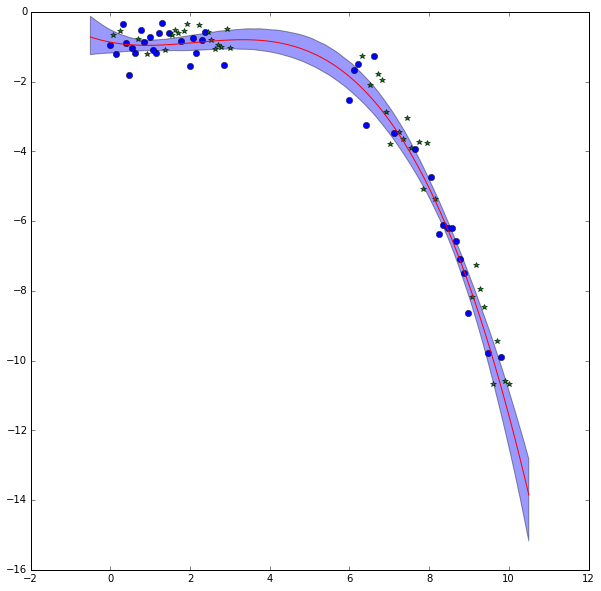

In [15]:
plt.figure(figsize=(10,10))
plt.plot(Xtrain[:,0],Ttrain,'o')
plt.plot(Xtest[:,0],Ttest,'*')

plt.fill_between(Xplot[:,0].flatten(),lower,upper,alpha=0.4)
plt.plot(Xplot[:,0],np.mean(Ys,axis=1),'r-');